# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import datasets, ndimage
from scipy.fft import dctn, idctn
import shutil
import os
import heapq
import cv2

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

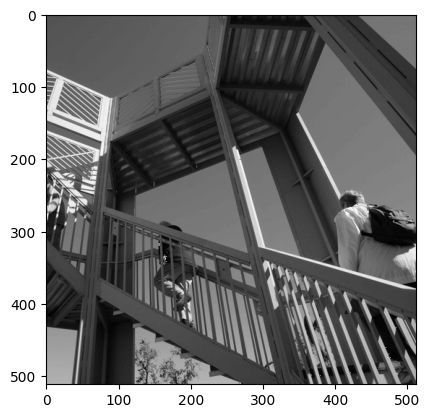

In [5]:
X = datasets.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

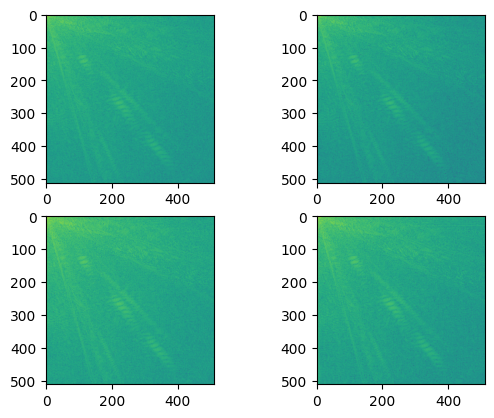

In [6]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

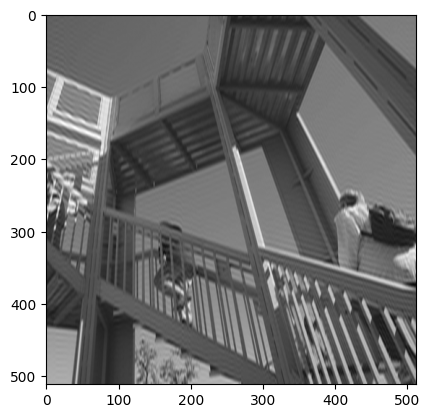

In [7]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

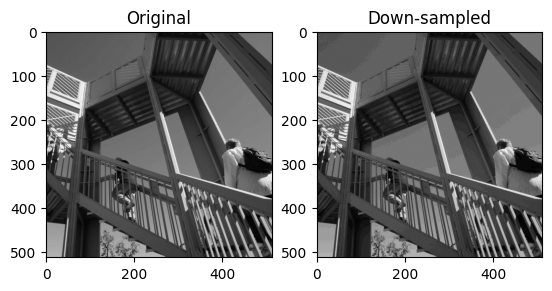

In [8]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

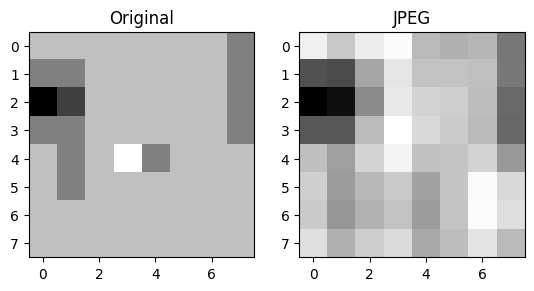

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [9]:
Q_jpeg = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]])

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr).

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

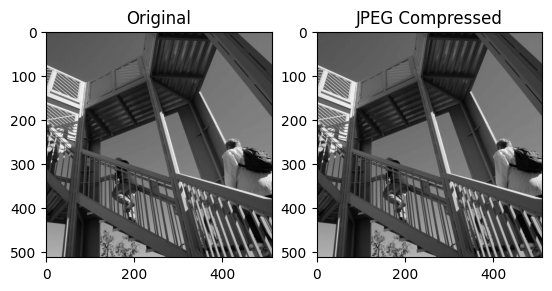

In [10]:
def quantify_dequantify_image(X, Q):
    X_jpeg = np.zeros_like(X)
    rows, cols = X.shape
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            block = X[i:i+8, j:j+8]
            dct_block = dctn(block)
            q_block = Q * np.round(dct_block / Q)
            idct_block = idctn(q_block)
            X_jpeg[i:i+8, j:j+8] = idct_block
    return X_jpeg

X_jpeg = quantify_dequantify_image(X, Q_jpeg)
plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('JPEG Compressed')
plt.show()

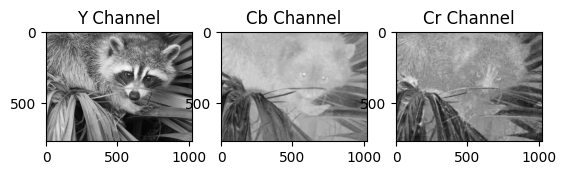

In [11]:
X = datasets.face()

# Got the numbers from https://www.w3.org/Graphics/JPEG/jfif3.pdf
def rgb2ycbcr(img):
    ycbcr = np.empty_like(img, dtype=np.float32)
    ycbcr[..., 0] =   0.299 * img[..., 0] +  0.587 * img[..., 1] +  0.114 * img[..., 2]
    ycbcr[..., 1] = -0.1687 * img[..., 0] - 0.3313 * img[..., 1] +    0.5 * img[..., 2] + 128
    ycbcr[..., 2] =     0.5 * img[..., 0] - 0.4187 * img[..., 1] - 0.0813 * img[..., 2] + 128
    return ycbcr

def ycbcr2rgb(img):
    rgb = np.empty_like(img, dtype=np.float32)
    rgb[..., 0] = img[..., 0] + 1.402 * (img[..., 2] - 128)
    rgb[..., 1] = img[..., 0] - 0.344136 * (img[..., 1] - 128) - 0.714136 * (img[..., 2] - 128)
    rgb[..., 2] = img[..., 0] + 1.772 * (img[..., 1] - 128)
    return rgb


X_ycbcr = rgb2ycbcr(X)
Y = X_ycbcr[..., 0]
Cb = X_ycbcr[..., 1]
Cr = X_ycbcr[..., 2]

plt.subplot(131).imshow(Y, cmap=plt.cm.gray)
plt.title('Y Channel')
plt.subplot(132).imshow(Cb, cmap=plt.cm.gray)
plt.title('Cb Channel')
plt.subplot(133).imshow(Cr, cmap=plt.cm.gray)
plt.title('Cr Channel')
plt.show()

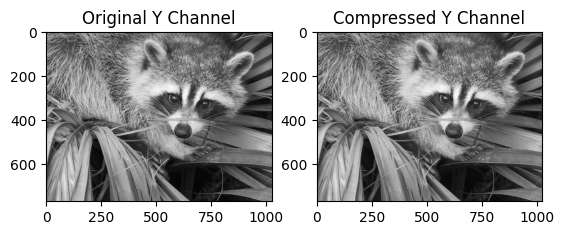

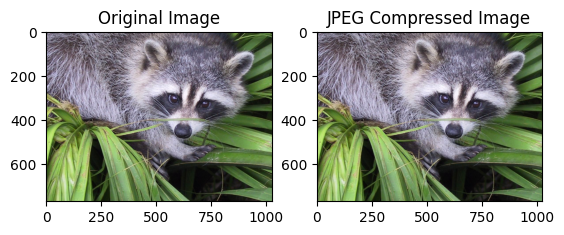

Original bytes:  [[121 112 131]
 [138 129 148]
 [153 144 165]
 ...
 [119 126  74]
 [131 136  82]
 [139 144  90]]
Compressed bytes:  [[120 111 130]
 [138 129 148]
 [153 144 165]
 ...
 [119 126  74]
 [130 135  81]
 [138 143  89]]


In [12]:
# Compress Y channel
Y_jpeg = quantify_dequantify_image(Y, Q_jpeg)
X_ycbcr_jpeg = np.zeros_like(X_ycbcr)
X_ycbcr_jpeg[..., 0] = Y_jpeg
X_ycbcr_jpeg[..., 1] = Cb
X_ycbcr_jpeg[..., 2] = Cr
plt.subplot(121).imshow(X_ycbcr[..., 0], cmap=plt.cm.gray)
plt.title('Original Y Channel')
plt.subplot(122).imshow(X_ycbcr_jpeg[..., 0], cmap=plt.cm.gray)
plt.title('Compressed Y Channel')
plt.show()

X_jpeg = ycbcr2rgb(X_ycbcr_jpeg).astype(np.uint8)
plt.subplot(121).imshow(X)
plt.title('Original Image')
plt.subplot(122).imshow(X_jpeg)
plt.title('JPEG Compressed Image')
plt.show()

# Making sure the images are different
print("Original bytes: ", X[0])
print("Compressed bytes: ", X_jpeg[0])

# Ordine zig-zag

Pentru ca compresia sa fie mai eficienta, vom folosi o ordonare zig-zag a coeficientilor DCT.

In [13]:
def zigzag_order(block):
    zigzag_indices = [
        (0,0),
        (0,1), (1,0),
        (2,0), (1,1), (0,2),
        (0,3), (1,2), (2,1), (3,0),
        (4,0), (3,1), (2,2), (1,3), (0,4),
        (0,5), (1,4), (2,3), (3,2), (4,1), (5,0),
        (6,0), (5,1), (4,2), (3,3), (2,4), (1,5), (0,6),
        (0,7), (1,6), (2,5), (3,4), (4,3), (5,2), (6,1), (7,0),
        (7,1), (6,2), (5,3), (4,4), (3,5), (2,6), (1,7),
        (2,7), (3,6), (4,5), (5,4), (6,3), (7,2),
        (3,7), (4,6), (5,5), (6,4), (7,3),
        (4,7), (5,6), (6,5), (7,4),
        (5,7), (6,6), (7,5),
        (6,7), (7,6),
        (7,7)
    ]
    return [block[i, j] for i, j in zigzag_indices]

def reverse_zigzag(coeffs):
    zigzag_indices = [
        (0,0),
        (0,1), (1,0),
        (2,0), (1,1), (0,2),
        (0,3), (1,2), (2,1), (3,0),
        (4,0), (3,1), (2,2), (1,3), (0,4),
        (0,5), (1,4), (2,3), (3,2), (4,1), (5,0),
        (6,0), (5,1), (4,2), (3,3), (2,4), (1,5), (0,6),
        (0,7), (1,6), (2,5), (3,4), (4,3), (5,2), (6,1), (7,0),
        (7,1), (6,2), (5,3), (4,4), (3,5), (2,6), (1,7),
        (2,7), (3,6), (4,5), (5,4), (6,3), (7,2),
        (3,7), (4,6), (5,5), (6,4), (7,3),
        (4,7), (5,6), (6,5), (7,4),
        (5,7), (6,6), (7,5),
        (6,7), (7,6),
        (7,7)
    ]
    block = np.zeros((8, 8))
    for idx, (i, j) in enumerate(zigzag_indices):
        block[i, j] = coeffs[idx]
    return block


# Implementare Run-Length Encoding

Dupa ce obtinem coeficientii DCT in ordine zig-zag, vom implementa o schema de Run-Length Encoding (RLE) pentru a comprima secventele de zerouri.

Algoritmul este preluat de pe [Wikipedia](https://en.wikipedia.org/wiki/JPEG). Nu am folosit codificare separata pentru coeficientii DC si AC, pentru simplitate.

In [14]:
def category(value):
    if value == 0:
        return 0
    abs_value = abs(value)
    return int(np.floor(np.log2(abs_value))) + 1


def amplitude_bits(value):
    if value == 0:
        return ''
    
    k = category(value)
    
    if value > 0:
        return format(value, 'b').zfill(k)
    else:
        magnitude = abs(value)
        complement = ((1 << k) - 1) ^ magnitude
        return format(complement, 'b').zfill(k)


def run_length_encode(coeffs):
    rle = []
    amplitudes = []
    zero_count = 0
    
    for coeff in coeffs:
        if coeff == 0:
            zero_count += 1
            if zero_count == 16:
                rle.append(0xF0)  # ZRL: 16 zeros
                amplitudes.append('')
                zero_count = 0
        else:
            rle.append((zero_count << 4) | category(coeff))
            amplitudes.append(amplitude_bits(int(coeff)))
            zero_count = 0

    # EOB: End of block if trailing zeros exist
    if zero_count > 0:
        rle.append(0x00)
        amplitudes.append('')
    
    return rle, amplitudes

def quantify_image(image, Q):
    rows, cols = image.shape
    rle_data = []
    amplitudes = []
    
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            block = image[i:i+8, j:j+8]
            dct_block = dctn(block)
            q_block = np.round(dct_block / Q)
            
            zigzag_coeffs = zigzag_order(q_block)
            rle_block, amplitude_block = run_length_encode(zigzag_coeffs)
            
            rle_data.extend(rle_block)
            amplitudes.extend(amplitude_block)
    
    return rle_data, amplitudes

# Implementare Huffman

- Folosim implementarea simpla de codificare Huffman
- Pentru a limita lungimea codurilor la 16 biti, folosim algoritmul de [limiting code lengths](https://en.wikipedia.org/wiki/Length-limited_Huffman_coding)
- Iar apoi generam [codurile canonice](https://en.wikipedia.org/wiki/Canonical_Huffman_code) pentru a reduce dimensiunea tabelei de codificare

In [15]:
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


def huffman_coding(data):
    heap = []
    for symbol, freq in data:
        heapq.heappush(heap, Node(symbol, freq))

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = Node(None, left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)

    return heap[0]

def generate_huffman_codes(node, prefix='', codes=None):
    if codes is None:
        codes = {}

    if node.symbol is not None:
        codes[node.symbol] = prefix if prefix else '0'
    else:
        if node.left:
            generate_huffman_codes(node.left, prefix + '0', codes)
        if node.right:
            generate_huffman_codes(node.right, prefix + '1', codes)

    return codes

def make_canonical(items):
    items.sort(key=lambda x: (x[1], x[0]))

    canonical_codes = {}
    code = 0
    prev_length = 0

    for symbol, length in items:
        code <<= (length - prev_length)
        canonical_codes[symbol] = format(code, '0{}b'.format(length))
        code += 1
        prev_length = length

    return canonical_codes


def limit_code_lengths(huffman_codes, max_length=16):
    items = [(sym, len(bits)) for sym, bits in huffman_codes.items()]
    adjusted_items = [(sym, min(length, max_length)) for sym, length in items]

    # Restore Kraft inequality by incrementing shortest codes
    kraft_sum = sum(2**(-length) for _, length in adjusted_items)
    while kraft_sum > 1.0:
        adjusted_items.sort(key=lambda x: x[1])
        sym, length = adjusted_items[0]
        if length < max_length:
            adjusted_items[0] = (sym, length + 1)
            kraft_sum = sum(2**(-length) for _, length in adjusted_items)
        else:
            break

    return make_canonical(adjusted_items)


In [16]:
def symbols(data):
    symbols = map(lambda x: (x, data.count(x)), set(data))
    return sorted(symbols, key=lambda x: x[1])

data = 'Let\'s encode this sentence with such a code'
symb = symbols(data)

print(symb)

[('w', 1), ('u', 1), ('L', 1), ('a', 1), ("'", 1), ('d', 2), ('i', 2), ('o', 2), ('h', 3), ('n', 3), ('s', 4), ('t', 4), ('c', 4), ('e', 7), (' ', 7)]


In [17]:
def build_bits_huffval_tables(canonical_codes):
    max_code_length = max(len(code) for code in canonical_codes.values())
    assert max_code_length <= 16, "Code lengths exceed 16 bits"

    bits = [0] * 16
    for code in canonical_codes.values():
        bits[len(code) - 1] += 1
    
    huffval = []
    for length in range(1, 17):
        symbols = [sym for sym, code in canonical_codes.items() if len(code) == length]
        symbols.sort()
        huffval.extend(symbols)
    
    return bits, huffval


def build_huffman_table(data):
    symb = symbols(data)
    huff_tree = huffman_coding(symb)
    codes = generate_huffman_codes(huff_tree)
    limited_codes = limit_code_lengths(codes, max_length=16)
    return limited_codes

huffman_table = build_huffman_table(data)
print(huffman_table)

{' ': '000', 'c': '001', 'e': '010', 's': '011', 'd': '1000', 'h': '1001', 'n': '1010', 'o': '1011', 't': '1100', "'": '11010', 'L': '11011', 'a': '11100', 'i': '11101', 'u': '11110', 'w': '11111'}


# Encodare si salvare JPEG

In [18]:
def encode_data(rle_data, amplitudes, canonical_codes):
    bitstream = []
    for symbol, amplitude in zip(rle_data, amplitudes):
        bitstream.append(canonical_codes[symbol])
        bitstream.append(amplitude)
    
    encoded = ''.join(bitstream)
    pad_len = (-len(encoded)) % 8
    encoded += '0' * pad_len

    # Convert to bytes
    data_bytes = bytes(int(encoded[i:i+8], 2) for i in range(0, len(encoded), 8))

    return data_bytes, pad_len


def save_encoded_file(filename, image, Q, canonical_codes, data_bytes, pad_len):
    rows, cols = image.shape
    rows_pad = (-rows) % 8
    cols_pad = (-cols) % 8
    bits, huffval = build_bits_huffval_tables(canonical_codes)

    with open(filename, 'wb') as f:
        f.write(b'MJPEG') # Matteo JPEG Magic number :D
        f.write(rows.to_bytes(4, 'big'))
        f.write(cols.to_bytes(4, 'big'))
        f.write(rows_pad.to_bytes(1, 'big'))
        f.write(cols_pad.to_bytes(1, 'big'))
        f.write(np.array(Q, dtype=np.uint8).tobytes())

        f.write(np.array(bits, dtype=np.uint8).tobytes())

        f.write(len(huffval).to_bytes(2, 'big'))
        f.write(np.array(huffval, dtype=np.uint8).tobytes())

        f.write(pad_len.to_bytes(1, 'big'))
        f.write(data_bytes)

def save_mjpeg_image(filename, image, Q):
    rle_data, amplitudes = quantify_image(image, Q)
    canonical_codes = build_huffman_table(rle_data)
    data_bytes, pad_len = encode_data(rle_data, amplitudes, canonical_codes)
    save_encoded_file(filename, image, Q, canonical_codes, data_bytes, pad_len)


X = datasets.ascent()

save_mjpeg_image('ascent.mjpeg', X, Q_jpeg)

file_size = os.path.getsize('ascent.mjpeg')
print(f"Size of 'ascent.mjpeg': {file_size} bytes")
print(f"Size of original image: {X.size} bytes")
print(f"Compression ratio: {X.size / file_size:.2f}")

Size of 'ascent.mjpeg': 116896 bytes
Size of original image: 262144 bytes
Compression ratio: 2.24


# Decodare JPEG si afisare imagine

In [19]:
def decode_image(filename):
    with open(filename, 'rb') as f:
        magic = f.read(5)
        assert magic == b'MJPEG', "Invalid file format"

        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        rows_pad = int.from_bytes(f.read(1), 'big')
        cols_pad = int.from_bytes(f.read(1), 'big')
        Q = np.frombuffer(f.read(64), dtype=np.uint8).reshape((8, 8))
        
        bits = list(f.read(16))
        huffval_length = int.from_bytes(f.read(2), 'big')
        huffval = list(f.read(huffval_length))
        
        pad_len = int.from_bytes(f.read(1), 'big')
        data_bytes = f.read()
    
    # Rebuild canonical codes from bits/huffval
    canonical_codes = {}
    huffval_idx = 0
    code = 0
    
    for length in range(1, 17):
        num_codes = bits[length - 1]
        for _ in range(num_codes):
            symbol = huffval[huffval_idx]
            code_str = format(code, '0' + str(length) + 'b')
            canonical_codes[code_str] = symbol
            huffval_idx += 1
            code += 1
        code <<= 1
    
    return rows, cols, rows_pad, cols_pad, Q, pad_len, canonical_codes, data_bytes


In [20]:
def split_amplitude(bitstream, index, symbol):
    if symbol == 0x00: # EOB
        return '', index
    elif symbol == 0xF0: # ZRL
        return '', index
    
    size = symbol & 0x0F
    if size == 0:
        return '', index
    amp_bits = bitstream[index:index + size]
    index += size

    return amp_bits, index
    

def split_bitstream(bitstream, canonical_codes):
    rle_decoded = []
    amp_decoded = []
    i = 0

    while i < len(bitstream):
        for length in range(1, 17):
            if i + length > len(bitstream):
                break

            code = bitstream[i:i + length]
            if code in canonical_codes:
                symbol = canonical_codes[code]
                rle_decoded.append(symbol)
                i += length

                amp, i = split_amplitude(bitstream, i, symbol)
                amp_decoded.append(amp)
                break
        else:
            raise ValueError("Invalid bitstream or Huffman codes")

    return rle_decoded, amp_decoded


def decode_bitstream(rle_data, amplitudes):
    coeffs = []
    idx = 0
    
    while idx < len(rle_data):
        symbol = rle_data[idx]
        amp_bits = amplitudes[idx]
        idx += 1

        if symbol == 0x00:  # EOB
            while len(coeffs) % 64 != 0:
                coeffs.append(0)
        elif symbol == 0xF0:  # ZRL
            coeffs.extend([0] * 16)
        else:
            run_length = (symbol >> 4) & 0x0F
            size = symbol & 0x0F
            
            # Add run_length zeros
            coeffs.extend([0] * run_length)
            
            # Decode amplitude
            if size > 0:
                if amp_bits[0] == '1':
                    amplitude = int(amp_bits, 2)
                else:
                    magnitude = int(amp_bits, 2)
                    amplitude = magnitude - (1 << size) + 1
            else:
                amplitude = 0
            
            coeffs.append(amplitude)
    
    return coeffs


def reconstruct_image(coeffs, Q, rows, cols):
    image = np.zeros((rows, cols))
    block_idx = 0
    
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            block_coeffs = coeffs[block_idx:block_idx + 64]
            block_idx += 64

            q_block = reverse_zigzag(block_coeffs)
            dequant_block = q_block * Q
            idct_block = idctn(dequant_block)

            image[i:i+8, j:j+8] = idct_block
    
    return image

In [21]:
def load_mjpeg_image(filename):
    rows, cols, rows_pad, cols_pad, Q, pad_len, canonical_codes, data_bytes = decode_image(filename)
    bitstream = ''.join(format(byte, '08b') for byte in data_bytes)
    bitstream = bitstream[:-pad_len] if pad_len > 0 else bitstream
    rle_data, amplitudes = split_bitstream(bitstream, canonical_codes)
    coeffs = decode_bitstream(rle_data, amplitudes)
    X_jpeg = reconstruct_image(coeffs, Q, rows + rows_pad, cols + cols_pad)
    X_jpeg = X_jpeg[:rows, :cols]
    return X_jpeg

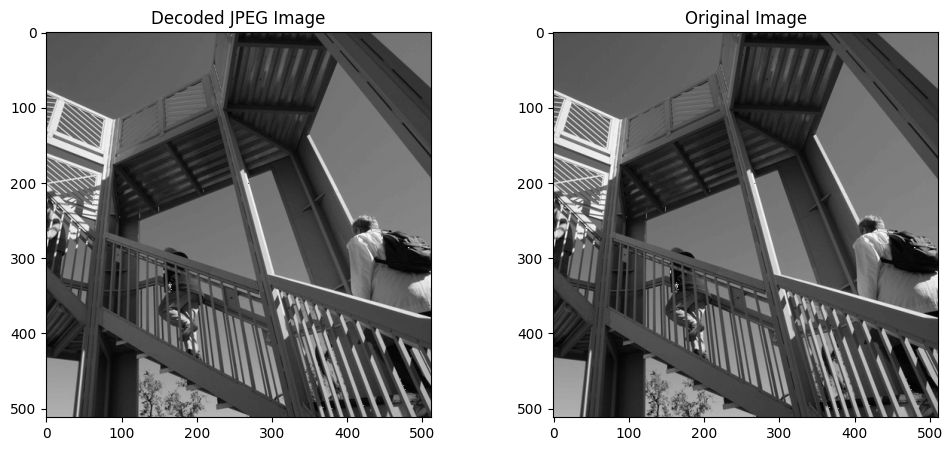

In [22]:
X_jpeg = load_mjpeg_image('ascent.mjpeg')
plt.figure(figsize=(12, 5))
plt.subplot(121).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Decoded JPEG Image')
plt.subplot(122).imshow(datasets.ascent(), cmap=plt.cm.gray)
plt.title('Original Image')
plt.show()

# Extindere la imagini color

Pentru imagini color, comprimam fiecare canal (Y, Cb, Cr) separat.

Original size: 2359296 bytes
Compressed size: 455348 bytes
Compression ratio: 5.18:1


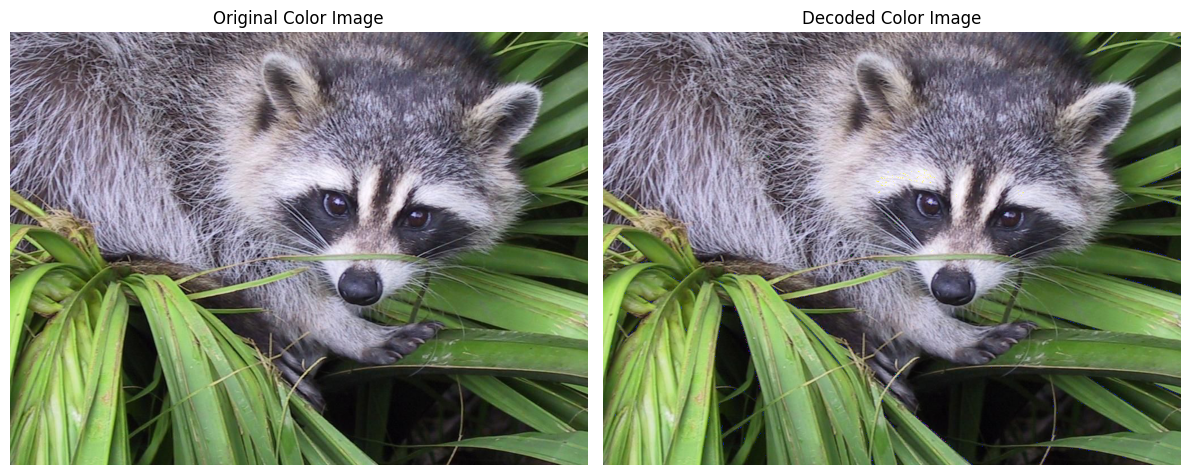

In [23]:
def save_color_jpeg(filename, image_rgb, Q):
    image_ycbcr = rgb2ycbcr(image_rgb)
    Y = image_ycbcr[..., 0]
    Cb = image_ycbcr[..., 1]
    Cr = image_ycbcr[..., 2]
    
    rows, cols = Y.shape
    rows_pad = (-rows) % 8
    cols_pad = (-cols) % 8
    
    # Compress each channel
    channels_data = []
    for channel in [Y, Cb, Cr]:
        rle_data, amplitudes = quantify_image(channel, Q)
        canonical_codes = build_huffman_table(rle_data)
        data_bytes, pad_len = encode_data(rle_data, amplitudes, canonical_codes)
        bits, huffval = build_bits_huffval_tables(canonical_codes)
        max_code_length = max(len(code) for code in canonical_codes.values())
        channels_data.append((data_bytes, pad_len, bits[:max_code_length], huffval, max_code_length))
    
    with open(filename, 'wb') as f:
        f.write(b'MJPEGC')  # Magic number for colored different than grayscale
        f.write(rows.to_bytes(4, 'big'))
        f.write(cols.to_bytes(4, 'big'))
        f.write(rows_pad.to_bytes(1, 'big'))
        f.write(cols_pad.to_bytes(1, 'big'))
        f.write(np.array(Q, dtype=np.uint8).tobytes())
        
        # Write data for each channel
        for data_bytes, pad_len, bits, huffval, max_code_length in channels_data:
            f.write(max_code_length.to_bytes(1, 'big'))
            f.write(np.array(bits, dtype=np.uint8).tobytes())
            f.write(len(huffval).to_bytes(2, 'big'))
            f.write(np.array(huffval, dtype=np.uint8).tobytes())
            f.write(pad_len.to_bytes(1, 'big'))
            f.write(len(data_bytes).to_bytes(4, 'big'))
            f.write(data_bytes)
    
    print(f"Original size: {image_rgb.size} bytes")
    print(f"Compressed size: {os.path.getsize(filename)} bytes")
    print(f"Compression ratio: {image_rgb.size / os.path.getsize(filename):.2f}:1")


def load_color_jpeg(filename):
    with open(filename, 'rb') as f:
        magic = f.read(6)
        assert magic == b'MJPEGC', "Not a color MJPEG file"
        
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        rows_pad = int.from_bytes(f.read(1), 'big')
        cols_pad = int.from_bytes(f.read(1), 'big')
        Q = np.frombuffer(f.read(64), dtype=np.uint8).reshape((8, 8))
        
        # Read data for each channel
        channels = []
        for _ in range(3):
            max_code_length = int.from_bytes(f.read(1), 'big')
            bits = list(f.read(max_code_length))
            huffval_length = int.from_bytes(f.read(2), 'big')
            huffval = list(f.read(huffval_length))
            pad_len = int.from_bytes(f.read(1), 'big')
            data_length = int.from_bytes(f.read(4), 'big')
            data_bytes = f.read(data_length)
            
            canonical_codes = {}
            huffval_idx = 0
            code = 0
            for length in range(1, max_code_length + 1):
                num_codes = bits[length - 1]
                for _ in range(num_codes):
                    symbol = huffval[huffval_idx]
                    code_str = format(code, '0' + str(length) + 'b')
                    canonical_codes[code_str] = symbol
                    huffval_idx += 1
                    code += 1
                code <<= 1
            
            bitstream = ''.join(format(byte, '08b') for byte in data_bytes)
            bitstream = bitstream[:-pad_len] if pad_len > 0 else bitstream
            rle_data, amplitudes = split_bitstream(bitstream, canonical_codes)
            coeffs = decode_bitstream(rle_data, amplitudes)
            channel = reconstruct_image(coeffs, Q, rows + rows_pad, cols + cols_pad)
            channel = channel[:rows, :cols]
            channels.append(channel)
    
    image_ycbcr = np.stack(channels, axis=-1)
    image_rgb = ycbcr2rgb(image_ycbcr).astype(np.uint8)
    
    return image_rgb


X_color = datasets.face()
save_color_jpeg('face.mjpeg', X_color, Q_jpeg)

X_color_decoded = load_color_jpeg('face.mjpeg')

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(X_color)
plt.title('Original Color Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(X_color_decoded)
plt.title('Decoded Color Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Compresie pana la un MSE tinta

- Folosim cautare binara pentru a gasi factorul de scalare al matricii de cuantizare care sa duca la MSE-ul tinta
- Nu mi-e clar cum pot sa fac asta pentru imagini color, dar merge bine pentru grayscale

In [24]:
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

print(compute_mse(X, X_jpeg))
print(compute_mse(X_color, X_color_decoded))

0.7308317967731521
0.5832210116916232


In [25]:
def compress_until_mse(image, target_mse, Q_base, is_color=False):
    # Do binary search
    # Higher scale = more compression = higher MSE
    # Lower scale = less compression = lower MSE
    scale_low = 1.0
    scale_high = 1000.0
    best_result = None

    result_filename = "result.mjpeg"

    iter = 0
    best_file_size = 0  # Track the file size for best result
    
    while scale_high - scale_low > 0.01:
        scale_factor = (scale_low + scale_high) / 2
        Q_scaled = Q_base * scale_factor

        temp_filename = "temp_compression.mjpeg"

        if is_color:
            save_color_jpeg(temp_filename, image, Q_scaled)
            compressed = load_color_jpeg(temp_filename)
        else:
            save_mjpeg_image(temp_filename, image, Q_scaled)
            compressed = load_mjpeg_image(temp_filename)

        actual_mse = compute_mse(image, compressed)
        file_size = os.path.getsize(temp_filename)

        print(f"Iteration {iter}: scale={scale_factor:.4f}, MSE={actual_mse:.4f}, size={file_size} bytes")

        if actual_mse < target_mse:
            shutil.copyfile(temp_filename, result_filename)
            best_result = (actual_mse, scale_factor)
            best_file_size = file_size
            scale_low = scale_factor
        else:
            scale_high = scale_factor
        
        iter += 1

    if best_result:
        actual_mse, scale_factor = best_result
        # Clean up temp file
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

        print(f"Achieved MSE: {actual_mse:.4f}")
        print(f"Target MSE: {target_mse:.4f}")
        print(f"File size: {best_file_size} bytes")
        print(f"Compression ratio: {image.size / best_file_size:.2f}:1")

        return actual_mse, scale_factor

    return None

In [26]:
def save_with_mse_target(filename, image, target_mse, Q_base, is_color=False):
    actual_mse, scale_factor = compress_until_mse(
        image, target_mse, Q_base, is_color
    )

    Q_scaled = Q_base * scale_factor

    if is_color:
        save_color_jpeg(filename, image, Q_scaled)
    else:
        rle_data, amplitudes = quantify_image(image, Q_scaled)
        canonical_codes = build_huffman_table(rle_data)
        data_bytes, pad_len = encode_data(rle_data, amplitudes, canonical_codes)
        save_encoded_file(filename, image, Q_scaled, canonical_codes, data_bytes, pad_len)

    print(f"\nSaved compressed image to: {filename}")
    return actual_mse

Iteration 0: scale=500.5000, MSE=9845.6440, size=6961 bytes
Iteration 1: scale=250.7500, MSE=9181.8226, size=9659 bytes
Iteration 2: scale=125.8750, MSE=7958.3542, size=13556 bytes
Iteration 3: scale=63.4375, MSE=5778.5070, size=19437 bytes
Iteration 4: scale=32.2188, MSE=9658.0606, size=26878 bytes
Iteration 5: scale=16.6094, MSE=8881.3715, size=36682 bytes
Iteration 6: scale=8.8047, MSE=34.0632, size=48529 bytes
Iteration 7: scale=12.7070, MSE=63.0812, size=41411 bytes
Iteration 8: scale=14.6582, MSE=78.5298, size=38910 bytes
Iteration 9: scale=15.6338, MSE=82.6824, size=37756 bytes
Iteration 10: scale=16.1216, MSE=9439.4896, size=37180 bytes
Iteration 11: scale=15.8777, MSE=81.8589, size=37455 bytes
Iteration 12: scale=15.9996, MSE=81.1903, size=37321 bytes
Iteration 13: scale=16.0606, MSE=9512.8664, size=37244 bytes
Iteration 14: scale=16.0301, MSE=9513.2076, size=37277 bytes
Iteration 15: scale=16.0149, MSE=9513.2596, size=37305 bytes
Iteration 16: scale=16.0073, MSE=9513.2600, si

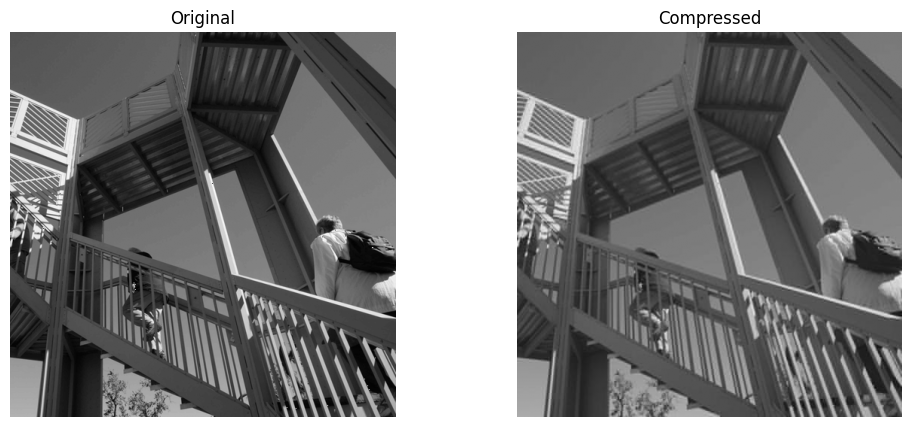

In [27]:
X = datasets.ascent() # Momentan nu am reusit sa comprim imagini color, nu stiu inca de ce
target_mse = 2000
save_with_mse_target('ascent_targeted.mjpeg', X, target_mse, Q_jpeg, is_color=False)

X_decoded = load_mjpeg_image('ascent_targeted.mjpeg')
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(X_decoded, cmap=plt.cm.gray)
plt.title('Compressed')
plt.axis('off')

print(f"Final MSE: {compute_mse(X, X_decoded):.4f}")

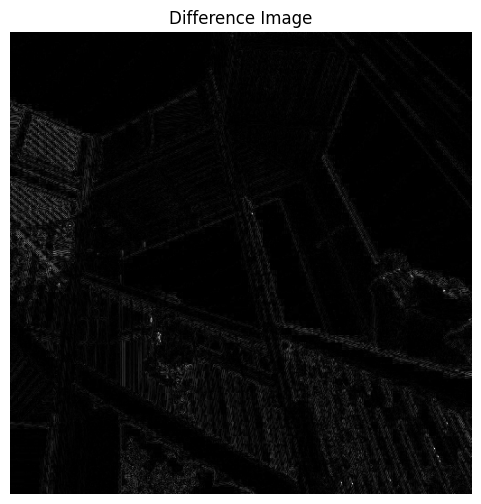

In [28]:
# Plot difference
difference = np.abs(X - X_decoded)
plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap=plt.cm.gray)
plt.title('Difference Image')
plt.axis('off')
plt.show()

In [36]:
def compress_video(input_video_path, output_video_path, Q, target_mse=None):
    cap = cv2.VideoCapture(input_video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {frame_width}x{frame_height} @ {fps} FPS, {total_frames} frames")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0

    for frame_count in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        print(f"Processing frame {frame_count}/{total_frames}...", end='\r')

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        temp_filename = f"temp_frame_{frame_count}.mjpeg"
        save_color_jpeg(temp_filename, frame_rgb, Q)

        frame_decompressed = load_color_jpeg(temp_filename)
        frame_bgr = cv2.cvtColor(frame_decompressed, cv2.COLOR_RGB2BGR)

        out.write(frame_bgr)
        os.remove(temp_filename)

    cap.release()
    out.release()

    total_original_size = os.path.getsize(input_video_path)
    total_compressed_size = os.path.getsize(output_video_path)
    print(f"Compressed size: {total_compressed_size} bytes")
    print(f"Compression ratio: {total_original_size / total_compressed_size:.2f}:1")


test_video_path = "test_video.mp4"
compressed_video_path = "compressed_video.mp4"
compress_video(test_video_path, compressed_video_path, Q_jpeg)

Video properties: 1280x720 @ 24.56464567488805 FPS, 27 frames
Original size: 2764800 bytes
Compressed size: 77594 bytes
Compression ratio: 35.63:1
Original size: 2764800 bytes
Compressed size: 307071 bytes
Compression ratio: 9.00:1
Original size: 2764800 bytes
Compressed size: 334757 bytes
Compression ratio: 8.26:1
Original size: 2764800 bytes
Compressed size: 329334 bytes
Compression ratio: 8.40:1
Original size: 2764800 bytes
Compressed size: 321452 bytes
Compression ratio: 8.60:1
Original size: 2764800 bytes
Compressed size: 335628 bytes
Compression ratio: 8.24:1
Original size: 2764800 bytes
Compressed size: 335765 bytes
Compression ratio: 8.23:1
Original size: 2764800 bytes
Compressed size: 317358 bytes
Compression ratio: 8.71:1
Original size: 2764800 bytes
Compressed size: 337633 bytes
Compression ratio: 8.19:1
Original size: 2764800 bytes
Compressed size: 320244 bytes
Compression ratio: 8.63:1
Original size: 2764800 bytes
Compressed size: 332106 bytes
Compression ratio: 8.33:1
Ori

# Mici concluzii

- Am observat ca suma dimensiunilor fisierelor comprimate ale cadrelor individuale este mai mare decat dimensiunea fisierului video mp4, ceea ce sugereaza ca mp4 foloseste tehnici suplimentare de compresie care nu sunt prezente in implementarea mea simpla de JPEG pe cadre individuale.
- Nu sunt foarte familiar cu felul in care mp4 comprima video-urile, dar presupun ca se leaga de similaritatile intre cadre consecutive pentru a reduce redundanta.
- Deci, o sa presupun ca algoritmul meu de compresie strica intr-un fel sau altul cum stie mp4 sa faca compresie video mai eficient, de aceea fisierul are dimensiune mai mare (in cazul meu, 2x pe un clip de 1 secunda, 1280x720@24.5 fps, audio trimmed)